# Implementación del modelo de ML


*Instalación de librerías:*

In [1]:
# Para el manejo y carga de datos
import pyarrow.parquet as pq
# Manipulación de datos
import pandas as pd
import numpy as np
import re
#Visualización de datos
import matplotlib.pyplot as plt
# Divisió del dataset
from sklearn.model_selection import train_test_split
# Selección de variables importantes
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
# Implementación de modelos
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from catboost import CatBoostClassifier
# Importar grilla para prueba
from sklearn.model_selection import GridSearchCV
# Medir tiempos
import time
# Métricas de evaluación del modelo
from sklearn.metrics import roc_auc_score
from sklearn.metrics import recall_score
from feature_engine.encoding import MeanEncoder
from feature_engine.selection import RecursiveFeatureElimination
from category_encoders import OrdinalEncoder
from scipy.stats.mstats import winsorize
# Guardar modelo
import joblib

In [2]:
# Modelos adicionales
"""
from catboost impoty CatBoostClassifier
from lightgbm import LGBMClassifier
"""

'\nfrom catboost impoty CatBoostClassifier\nfrom lightgbm import LGBMClassifier\n'

*Lectura del dataset:*

In [3]:
df = pd.read_parquet("../../application_data_procesada.parquet")

*Visualización de las primeras filas:*

In [4]:
df.head(3)

,ID_CREDITO,OBJETIVO,TIPO_PAGO,GENERO,PROP_AUTO,PROP_INMUEBLE,CANTIDAD_HIJOS,INGRESO,MONTO_CREDITO,ANUALIDAD_PRESTAMO,...,CALIFICACION_REGION_CLIENTE_CIUDAD,DIA_SEMANA_SOLICITUD,HORA_SOLICITUD,DIRECCION_PERMANENTE_NO_DIRECCION_CONTACTO,DIRECCION_PERMANENTE_NO_DIRECCION_TRABAJO,DIRECCION_CONTACTO_NO_DIRECCION_TRABAJO,NO_VIVE_CIUDAD_REGISTRADA,NO_TRABAJA_CIUDAD_REGISTRADA,NO_VIVE_CIUDAD_DE_TRABAJO,TIPO_ORGANIZACION
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,1,MONDAY,11,0,0,0,0,0,0,School
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,2,MONDAY,9,0,0,0,0,0,0,Government


*Listado de columnas:*

In [5]:
df.columns

Index(['ID_CREDITO', 'OBJETIVO', 'TIPO_PAGO', 'GENERO', 'PROP_AUTO',
       'PROP_INMUEBLE', 'CANTIDAD_HIJOS', 'INGRESO', 'MONTO_CREDITO',
       'ANUALIDAD_PRESTAMO', 'PRECIO_BIENES', 'TIPO_ACOMPAÑANTE',
       'TIPO_INGRESO', 'NIVEL_ESTUDIO', 'ESTADO_CIVIL', 'TIPO_VIVIENDA',
       'POBLACION_RELATIVA_REGION', 'EDAD_DIAS', 'DIAS_EMPLEADO',
       'DIAS_MODIF_REGISTRO', 'DIAS_MODIF_DOCUMENTO', 'TIENE_CELULAR',
       'TELEFONO_EMPLEO', 'TELEFONO_TRABAJO', 'ATIENDE_CELULAR',
       'TELEFONO_CASA', 'EMAIL', 'PROFESION', 'CANTIDAD_MIEMBROS_FAMILIA',
       'CALIFICACION_REGION_CLIENTE', 'CALIFICACION_REGION_CLIENTE_CIUDAD',
       'DIA_SEMANA_SOLICITUD', 'HORA_SOLICITUD',
       'DIRECCION_PERMANENTE_NO_DIRECCION_CONTACTO',
       'DIRECCION_PERMANENTE_NO_DIRECCION_TRABAJO',
       'DIRECCION_CONTACTO_NO_DIRECCION_TRABAJO', 'NO_VIVE_CIUDAD_REGISTRADA',
       'NO_TRABAJA_CIUDAD_REGISTRADA', 'NO_VIVE_CIUDAD_DE_TRABAJO',
       'TIPO_ORGANIZACION'],
      dtype='object')

*Procesamiento del nombre de las columnas y conversión a minúscula:*

In [6]:
def to_snake_case(col):
    col = col.replace(' ', '_')
    p = re.sub('(.)([A-Z][a-z]+)', r'\1_\2', col)
    return re.sub('([a-z0-9])(A-Z)', r'\1_\2', p).lower()

*Aplicación de la función definida previamente:*

In [7]:
df.columns = [to_snake_case(col) for col in df.columns]

Dado que queremos realizar distintos modelos, lo más recomendable es transformar cada uno de los datos para que todos los modelos puedan procesarlos fácilmente.
- Columnas numéricas: escalarlas con StandardScaler()
- Columnas dicotómicas: aplicar OneHotEncoder()
- Columnas categóricas con demasiadas categorías: es mejor aplicar codificación de etiquetas para no generar un gran número de columnas. 
- Columnas ordinales: aplicar una codificación ordinal.

Es recomendable realizar una lista con aquellas columnas que recibirán el mismo tratamiento para los modelos. Se excluyen las columnas de `ID_CREDITO` Y `OBJETIVO` porque la primera no agregará información al modelo y la segunda es nuestra variable objetivo.

In [8]:
# Columnas numéricas: columnas con valores numéricos y cero absolutos.
numerical_x = ['cantidad_hijos', 'ingreso', 'monto_credito', 'anualidad_prestamo', 'precio_bienes', 'edad_dias', 'dias_empleado', 'dias_modif_registro', 'dias_modif_documento',
                'cantidad_miembros_familia']

# Columnas ordinales: columnas cuyos valores dependen del orden. 
ord_x = ['nivel_estudio', 'tipo_vivienda', 'tipo_ingreso', 'estado_civil', 'profesion']

# Lista de variables dicotómicas: columnas cuyos valores son 0/1 o Y/N
dichotomic_x = ['tipo_pago', 'prop_auto', 'prop_inmueble', 'tiene_celular', 'telefono_empleo', 'telefono_trabajo', 'atiende_celular', 'telefono_casa','email',
                'direccion_permanente_no_direccion_contacto', 'direccion_permanente_no_direccion_trabajo', 'direccion_contacto_no_direccion_trabajo', 'no_vive_ciudad_registrada',
                'no_trabaja_ciudad_registrada', 'no_vive_ciudad_de_trabajo']

# Lista de variables categóricas: columnas cuyos valores son categóricos y no dependen del orden.
categorical_x = ['tipo_organizacion', 'dia_semana_solicitud']

# Corroborar que están todas las columnas: deben ser 36
len(numerical_x) + len(ord_x) + len(dichotomic_x) + len(categorical_x)

32

*Análisis del resumen estadistico del DataFrame, por partes, para visualizar con claridad cada una de las columnas:*

In [9]:
df.iloc[:,0:18].describe()

,id_credito,objetivo,cantidad_hijos,ingreso,monto_credito,anualidad_prestamo,precio_bienes,poblacion_relativa_region,edad_dias
count,307511.000000,307511.000000,307511.000000,3.075110e+05,3.075110e+05,307511.000000,3.075110e+05,307511.000000,307511.000000
mean,278180.518577,0.080729,0.417052,1.687979e+05,5.990260e+05,27108.573909,5.383962e+05,0.020868,-16036.995067
std,102790.175348,0.272419,0.722121,2.371231e+05,4.024908e+05,14493.454517,3.692794e+05,0.013831,4363.988632
min,100002.000000,0.000000,0.000000,2.565000e+04,4.500000e+04,1615.500000,4.050000e+04,0.000290,-25229.000000
25%,189145.500000,0.000000,0.000000,1.125000e+05,2.700000e+05,16524.000000,2.385000e+05,0.010006,-19682.000000
50%,278202.000000,0.000000,0.000000,1.471500e+05,5.135310e+05,24903.000000,4.500000e+05,0.018850,-15750.000000
75%,367142.500000,0.000000,1.000000,2.025000e+05,8.086500e+05,34596.000000,6.795000e+05,0.028663,-12413.000000
max,456255.000000,1.000000,19.000000,1.170000e+08,4.050000e+06,258025.500000,4.050000e+06,0.072508,-7489.000000


In [10]:
df.iloc[:,18:28].describe()

,dias_empleado,dias_modif_registro,dias_modif_documento,tiene_celular,telefono_empleo,telefono_trabajo,atiende_celular,telefono_casa,email
count,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000
mean,63815.045904,-4986.120328,-2994.202373,0.999997,0.819889,0.199368,0.998133,0.281066,0.056720
std,141275.766519,3522.886321,1509.450419,0.001803,0.384280,0.399526,0.043164,0.449521,0.231307
min,-17912.000000,-24672.000000,-7197.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-2760.000000,-7479.500000,-4299.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000
50%,-1213.000000,-4504.000000,-3254.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000
75%,-289.000000,-2010.000000,-1720.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000
max,365243.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [11]:
df.iloc[:,28:35].describe()

,cantidad_miembros_familia,calificacion_region_cliente,calificacion_region_cliente_ciudad,hora_solicitud,direccion_permanente_no_direccion_contacto,direccion_permanente_no_direccion_trabajo
count,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000
mean,2.152651,2.052463,2.031521,12.063419,0.015144,0.050769
std,0.910695,0.509034,0.502737,3.265832,0.122126,0.219526
min,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
25%,2.000000,2.000000,2.000000,10.000000,0.000000,0.000000
50%,2.000000,2.000000,2.000000,12.000000,0.000000,0.000000
75%,3.000000,2.000000,2.000000,14.000000,0.000000,0.000000
max,20.000000,3.000000,3.000000,23.000000,1.000000,1.000000


In [12]:
df.iloc[:,35:40].describe()

,direccion_contacto_no_direccion_trabajo,no_vive_ciudad_registrada,no_trabaja_ciudad_registrada,no_vive_ciudad_de_trabajo
count,307511.000000,307511.000000,307511.000000,307511.000000
mean,0.040659,0.078173,0.230454,0.179555
std,0.197499,0.268444,0.421124,0.383817
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000


*Observar la cantidad y calidad de **días_empleado**, tienen valores atipicos (extremadamente altos):*

In [13]:
df.query('dias_empleado > 360000').iloc[:,18:19].describe()

,dias_empleado
count,55374.0
mean,365243.0
std,0.0
min,365243.0
25%,365243.0
50%,365243.0
75%,365243.0
max,365243.0


### Observaciones generales
- Tenemos alrededor de 24,826 valores objetivo.
- La cantidad de hijos (y por lo tanto los miembros de la familia) tienen valores atípicos.
- El ingreso también tiene valores atípicos.
- Los montos del crédito y las anualidades parecen estar mejor distribuidos. 
- Se recomienda cambiar los `DIAS_EMPLEADO` Y `EDAD_DIAS` de días a años en valores positivos.
- Se propone la eliminación de las columnas de `tiene_celular` y `atiende_celular` ya que son practicamente el 99% 
- La columna de `dias_empleado` tiene valores imposibles (empleado desde hace 1000 años). Podemos sustituir estos valores por la media o eliminar la columna.

## Observar la distribución de los datos mediante histogramas

In [14]:
# Observaciones
"""
df.iloc[:,0:15].hist(bins=30, figsize= (10,10))
plt.show()
"""

'\ndf.iloc[:,0:15].hist(bins=30, figsize= (10,10))\nplt.show()\n'

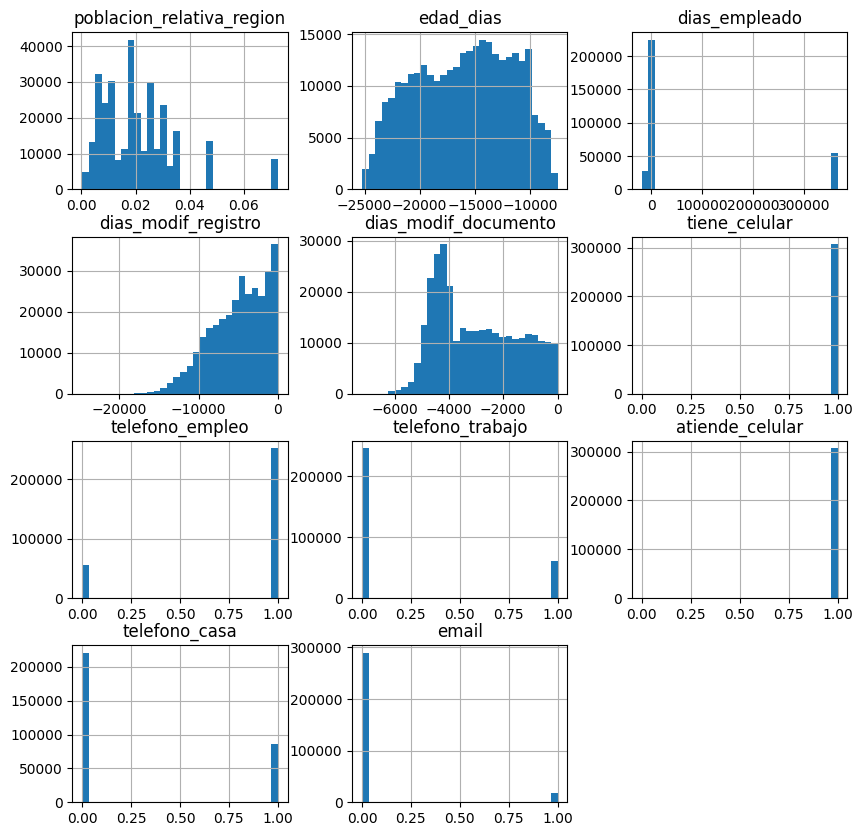

In [15]:
df.iloc[:,15:28].hist(bins=30, figsize= (10,10))
plt.show()

In [16]:
"""
df.iloc[:,28:39].hist(bins=30, figsize= (10,10))
plt.show()
"""

'\ndf.iloc[:,28:39].hist(bins=30, figsize= (10,10))\nplt.show()\n'

### Observaciones generales
- Casi todas las distribuciones de las variables numéricas tienen valores extremos. Esto es de esperarse ya que son variables relacionadas con el ingreso.
- Las variables dicotómicas conservan un valor de más de 70% en cualquiera de las dos categorías.
- Todas las distribuciones numéricas tienen datos sesgados. `edad_dias` tiene la distribución más parecida a una distribución normal.

## Correlación entre variables

Idealmente podríamos observar un gráfico con las relaciones entre pares de variables. No obstante, la gran cantidad de datos hace que sea más viable simplemente calcular  la correlación lineal.

In [17]:
# Graficar una muestra de los datos
"""
pd.plotting.scatter_matrix(df[numerical_x].sample(frac=.3, random_state=42), alpha=0.3, figsize=(12,12));
"""

'\npd.plotting.scatter_matrix(df[numerical_x].sample(frac=.3, random_state=42), alpha=0.3, figsize=(12,12));\n'

*Observar el grado de correlación lineal entre variables:*

In [18]:
(df[numerical_x].corr()).round(3)

,cantidad_hijos,ingreso,monto_credito,anualidad_prestamo,precio_bienes,edad_dias,dias_empleado,dias_modif_registro,dias_modif_documento,cantidad_miembros_familia
cantidad_hijos,1.000,0.013,0.002,0.021,-0.002,0.331,-0.240,0.183,-0.028,0.879
ingreso,0.013,1.000,0.157,0.192,0.160,0.027,-0.064,0.028,0.009,0.016
monto_credito,0.002,0.157,1.000,0.770,0.987,-0.055,-0.067,0.010,-0.007,0.063
anualidad_prestamo,0.021,0.192,0.770,1.000,0.775,0.009,-0.104,0.039,0.011,0.076
precio_bienes,-0.002,0.160,0.987,0.775,1.000,-0.053,-0.065,0.012,-0.009,0.061
edad_dias,0.331,0.027,-0.055,0.009,-0.053,1.000,-0.616,0.332,0.273,0.279
dias_empleado,-0.240,-0.064,-0.067,-0.104,-0.065,-0.616,1.000,-0.210,-0.272,-0.234
dias_modif_registro,0.183,0.028,0.010,0.039,0.012,0.332,-0.210,1.000,0.102,0.173
dias_modif_documento,-0.028,0.009,-0.007,0.011,-0.009,0.273,-0.272,0.102,1.000,-0.021
cantidad_miembros_familia,0.879,0.016,0.063,0.076,0.061,0.279,-0.234,0.173,-0.021,1.000


### Observaciones generales

- La distribución entre `dias_modif_documento` y `edad_dias` es muy particular. Tiene dos "dientes" que hacen que conforme la edad avanza los días se dispersan cada vez menos. Pero a partir de cierta edad, la distribución se repite una vez más.
- Una situación similar ocurre con `dias_modif_registo` y `edad_dias`. Conforme la edad avanza, los días de modificación del registro aumentan.

Las correlaciones lineales relativamente fuertes entre variables son:
- Monto de crédito y precio bienes: .987
- Cantidad de hijos con cantidad de miembros de la familia 0.879
- Anualidad y monto del préstamo: .770
- Precio de los bienes y su anualidad: .775

Lo anterior tiene sentido ya que los montos de los préstamos deben estar relacionados directamente con el monto de crédito y su anualidad.

*Ajuste de valores de columnas `dias_empleado`, `edad_dias`, `dias_modif_registro`, `dias_modif_documento`:*

<Axes: ylabel='Frequency'>

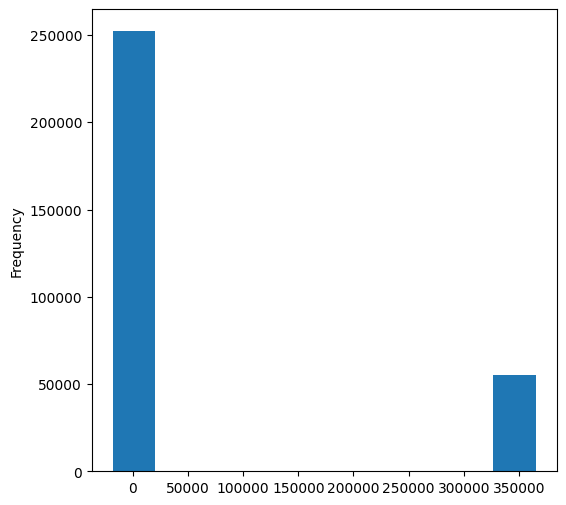

In [19]:
df.query('dias_empleado < 3700000')['dias_empleado'].plot(kind='hist', figsize = (6,6))

*Distribución de la columna **dias_empleado** sin valores atípicos:*

<Axes: ylabel='Frequency'>

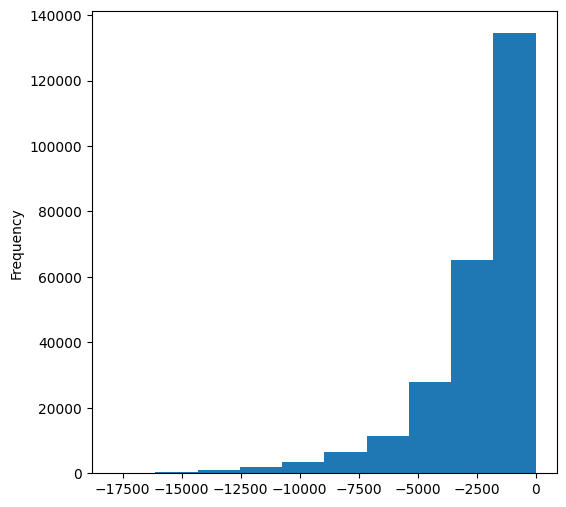

In [20]:
df.query('dias_empleado < 0')['dias_empleado'].plot(kind='hist', figsize=(6,6))

*Observaciones generales:*

> Los días empleado mayores a 365000 no son posibles, se recomienda sustituir valores extremos por la moda.

*Conteo de valores de la columna **genero**:*

In [21]:
df['genero'].value_counts()

genero
F      202448
M      105059
XNA         4
Name: count, dtype: int64

*Transformaciones previas al entrenamiento del modelo:*

In [22]:
# Dada la distribución de los datos, lo mejor es sustituir los valores exrtremos por la moda de los valores correctos.
mode_dias_empleado = df.query("dias_empleado < 0")['dias_empleado'].mode()
# Sustituir los datos extremos por la moda
df['dias_empleado'] = np.where(df['dias_empleado']>365000, mode_dias_empleado, df['dias_empleado'])
# ELiminar la tercer categoría de genero de 6 columnas.
df['genero'] = np.where(df['genero']=="XNA", 'F', df['genero'])
# Convertir valores a años positivos
df['dias_modif_registro'] = (df['dias_modif_registro'] / - 365).round(0)
# Convertir valores a años positivos
df['dias_modif_documento'] = (df['dias_modif_documento'] / -365).round(0)
# Convertir `dias_empleado` a años positivos
df['dias_empleado'] = (df['dias_empleado'] / -365).round()
# Convertir el tipo de dato de 'dias_empleado' a int
df['dias_empleado'] = df['dias_empleado'].astype(int)
# Convertir edad en días a años positivos
df['edad_dias'] = (df['edad_dias'] / - 365).round(0)
# Convertir el tipo de dato de 'edad_dias' a int
df['edad_dias'] = df['edad_dias'].astype(int)

*Corroborar los cambios realizados:*

In [23]:
df[['dias_empleado', 'dias_modif_registro', 'dias_modif_documento', 'edad_dias']].describe()

,dias_empleado,dias_modif_registro,dias_modif_documento,edad_dias
count,307511.000000,307511.000000,307511.000000,307511.000000
mean,5.536413,13.659440,8.198575,43.938646
std,6.182681,9.659369,4.151520,11.964047
min,0.000000,0.000000,0.000000,21.000000
25%,1.000000,6.000000,5.000000,34.000000
50%,3.000000,12.000000,9.000000,43.000000
75%,8.000000,20.000000,12.000000,54.000000
max,49.000000,68.000000,20.000000,69.000000


### Preprocesamiento de datos para implementación en los modelos


*Extraer variable objetivo del conjunto de datos, y dividir el conjunto de datos para entrenamiento y prueba:*

In [24]:
x = df.drop(['objetivo', 'id_credito', 'poblacion_relativa_region', 'hora_solicitud', 'genero', 'tipo_acompañante'], axis = 1)
# Variable objetivo
y = df['objetivo']

*Extraer conjunto de entrenamiento del conjunto de prueba:*

In [25]:
# Conjunto de entrenamiento y prueba.
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=.3, random_state=42)
# Confirmar tamaño de los nuevos data sets
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((215257, 34), (92254, 34), (215257,), (92254,))

*Observar cuántos valores objetivo cayeron en cada dataset:*

In [26]:
y_train.sum(), y_test.sum()

(17412, 7413)

### Tratameinto de columnas numéricas:

In [27]:
# Eliminar valores extremos en columnas numéricas 
#########################No me ha dado los resultados que esperaba #####################
"""
df2 = pd.DataFrame(winsorize(x_train[numerical_x].to_numpy(), limits=(0.2, 0.2), inplace=True), columns=numerical_x);
pd.plotting.scatter_matrix(df2)
"""

'\ndf2 = pd.DataFrame(winsorize(x_train[numerical_x].to_numpy(), limits=(0.2, 0.2), inplace=True), columns=numerical_x);\npd.plotting.scatter_matrix(df2)\n'

In [28]:
# Crear una instancia para el escalado de datos numéricos
scaler = StandardScaler()
# Ajustar y transformar el conjunto de entrenamiento
x_train[numerical_x] = scaler.fit_transform(x_train[numerical_x])
# Ajustar y transformar el conjunto de prueba 
x_test[numerical_x] = scaler.transform(x_test[numerical_x])
# Observar las transformaciones realizadas.
x_train.head(3)


,tipo_pago,prop_auto,prop_inmueble,cantidad_hijos,ingreso,monto_credito,anualidad_prestamo,precio_bienes,tipo_ingreso,nivel_estudio,...,calificacion_region_cliente,calificacion_region_cliente_ciudad,dia_semana_solicitud,direccion_permanente_no_direccion_contacto,direccion_permanente_no_direccion_trabajo,direccion_contacto_no_direccion_trabajo,no_vive_ciudad_registrada,no_trabaja_ciudad_registrada,no_vive_ciudad_de_trabajo,tipo_organizacion
127044,Cash loans,N,N,-0.578908,-0.104452,0.265362,2.751246,0.380564,Commercial associate,Higher education,...,1,1,WEDNESDAY,0,0,0,0,0,0,Services
281143,Cash loans,Y,Y,0.810571,-0.444539,-0.135161,-0.117939,-0.240303,Working,Secondary / secondary special,...,2,2,MONDAY,0,0,0,0,0,0,Business Entity Type 3
199799,Cash loans,Y,Y,0.810571,0.533210,0.850846,0.038550,0.368391,Working,Secondary / secondary special,...,2,2,THURSDAY,0,0,0,0,0,0,Self-employed


### Aplicar OrdinalEncoder() a las columnas ordinales

In [29]:
# Primero determinar el mapeo de los datos
maplist = [{'col':'tipo_vivienda', 'mapping':{None:0, 'With parents':1, 'Municipal apartment':2, 'Co-op apartment':3, 'Rented aparment':4, 'Office apartment':5, 'House / apartment':6}},
           {'col':'nivel_estudio', 'mapping':{None:0, 'Lower secondary':1, 'Secondary / secondary special':2, 'Incomplete higher':3, 'Higher education':4, 'Academic degree':5}},
           {'col':'tipo_ingreso', 'mapping':{None:0, 'Commercial associate':6, 'Working':5, 'Pensioner':4, 'State servant':7, 'Student':2, 'Maternity leave':3, 'Unemployed':1, 'Businessman':8}},
           {'col':'estado_civil', 'mapping':{None:0, 'Married':5, 'Separated':3, 'Civil marriage':6, 'Single / not married':4, 'Widow':2, 'Unknown':1}},
           {'col': 'profesion', 'mapping': {None:0, 'Laborers':1, 'Core staff':2, 'Accountants':3, 'Managers':4, 'Other':5, 'Drivers':6, 'Sales staff':7, 'Cleaning staff':8, 'Cooking staff':9, 'Private service staff':10, 'Medicine staff':11, 'Security staff':12, 'High skill tech staff':13, 'Waiters/barmen staff':14, 'Low-skill Laborers':15, 'Realty agents':16, 'Secretaries':17, 'IT staff':18, 'HR staff':19}},
           ]

In [30]:
oe = OrdinalEncoder(mapping=maplist)

In [31]:
x_train_oe = oe.fit_transform(x_train)
x_test_oe = oe.transform(x_test)

In [32]:
x_train_oe[['tipo_vivienda', 'estado_civil']].head()

,tipo_vivienda,estado_civil
127044,6.0,5
281143,6.0,5
199799,2.0,5
306749,6.0,3
301347,6.0,6


In [33]:
"""
Mi intento de quitar filas en el entrenamiento
# Obtener el índice de todos los valores que son iguales a uno desde y_test
x_train_target = x_train_completed[y_train.reset_index(drop=True) == 1 ]
x_train_no_target = x_train_completed[y_train.reset_index(drop=True) == 0 ]
#Obtener una muestra de x_test_no_target
#x_test_no_target_sample = x_test_no_target.sample()
"""

'\nMi intento de quitar filas en el entrenamiento\n# Obtener el índice de todos los valores que son iguales a uno desde y_test\nx_train_target = x_train_completed[y_train.reset_index(drop=True) == 1 ]\nx_train_no_target = x_train_completed[y_train.reset_index(drop=True) == 0 ]\n#Obtener una muestra de x_test_no_target\n#x_test_no_target_sample = x_test_no_target.sample()\n'

### Aplicar MeanEncoder() a las columnas categóricas no ordinales

In [34]:
x_train[categorical_x].head(3)

,tipo_organizacion,dia_semana_solicitud
127044,Services,WEDNESDAY
281143,Business Entity Type 3,MONDAY
199799,Self-employed,THURSDAY


In [35]:
#crear Instancia
mean_encoder= MeanEncoder(variables=categorical_x, ignore_format=False)
# C# Aplicar fit_transform al conjunto de entre (esta cosa ya te entrega un dataframe)
mean_encoder_x = mean_encoder.fit_transform(x_train_oe[categorical_x], y_train)
# Aplicar la misma transfomación al conjunto de entrenamiento
mean_encoder_x_test = mean_encoder.transform(x_test_oe[categorical_x])
# Agregar las columnas al dataframe original.
x_train_mean_e = pd.concat([x_train_oe.drop(columns = categorical_x), mean_encoder_x], axis=1)
x_test_mean_e = pd.concat([x_test_oe.drop(columns = categorical_x), mean_encoder_x_test], axis=1)
x_test_mean_e.head(2)

c:\Users\ferna\OneDrive\Escritorio\Proyecto_Deteccion_Dificultad_Pago\proyectonc\Lib\site-packages\feature_engine\encoding\mean_encoding.py:230: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  _lambda * y.groupby(X[var]).mean() + (1.0 - _lambda) * y_prior
c:\Users\ferna\OneDrive\Escritorio\Proyecto_Deteccion_Dificultad_Pago\proyectonc\Lib\site-packages\feature_engine\encoding\mean_encoding.py:230: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  _lambda * y.groupby(X[var]).mean() + (1.0 - _lambda) * y_prior


,tipo_pago,prop_auto,prop_inmueble,cantidad_hijos,ingreso,monto_credito,anualidad_prestamo,precio_bienes,tipo_ingreso,nivel_estudio,...,calificacion_region_cliente,calificacion_region_cliente_ciudad,direccion_permanente_no_direccion_contacto,direccion_permanente_no_direccion_trabajo,direccion_contacto_no_direccion_trabajo,no_vive_ciudad_registrada,no_trabaja_ciudad_registrada,no_vive_ciudad_de_trabajo,tipo_organizacion,dia_semana_solicitud
245895,Cash loans,Y,N,2.200051,0.363166,-0.332686,1.757459,-0.325520,6,2,...,2,2,0,0,0,0,1,1,0.09344,0.08088
98194,Cash loans,Y,Y,-0.578908,0.745764,1.693274,1.503047,1.731864,6,4,...,3,3,0,0,0,0,0,0,0.09344,0.08088


In [36]:
x_train_mean_e.shape

(215257, 34)

### Tratamiento de columnas dicotómicas


In [37]:
# Crear instancia de OHE
ohe = OneHotEncoder(drop='first', sparse_output=False)

# Crear un dataframe con los valores bianrios del conjunto de entrenamiento
ohe_x = pd.DataFrame(ohe.fit_transform(x_train_mean_e[dichotomic_x]), columns = dichotomic_x)
# crear un df con los valores binarios del conjunto prueba.
ohe_x_test = pd.DataFrame(ohe.transform(x_test_mean_e[dichotomic_x]), columns = dichotomic_x)
# Concatenar con el dataframe original y eliminar las columnas repetidas (train)
x_train_ohe = pd.concat([x_train_mean_e.drop(columns=dichotomic_x).reset_index(drop=True),ohe_x], axis=1)
# Concatenar con el dataframe original y eliminar las columnas repetidas (test)
x_test_ohe = pd.concat([x_test_mean_e.drop(columns = dichotomic_x).reset_index(drop=True), ohe_x_test], axis=1)
# Observar primeras tres columnas del nuevo df 
x_test_ohe.head(3)

,cantidad_hijos,ingreso,monto_credito,anualidad_prestamo,precio_bienes,tipo_ingreso,nivel_estudio,estado_civil,tipo_vivienda,edad_dias,...,telefono_trabajo,atiende_celular,telefono_casa,email,direccion_permanente_no_direccion_contacto,direccion_permanente_no_direccion_trabajo,direccion_contacto_no_direccion_trabajo,no_vive_ciudad_registrada,no_trabaja_ciudad_registrada,no_vive_ciudad_de_trabajo
0,2.200051,0.363166,-0.332686,1.757459,-0.325520,6,2,5,6.0,-0.663026,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
1,-0.578908,0.745764,1.693274,1.503047,1.731864,6,4,4,6.0,-0.328527,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.578908,0.320656,-0.259361,0.825647,-0.118564,5,2,5,6.0,0.424096,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [39]:
# Verificar dimensiones
x_train_ohe.shape, x_test_ohe.shape

((215257, 34), (92254, 34))

### Conjuntos de datos para aplicar los modelos

In [40]:
x_train_ohe.shape

(215257, 34)

## Selección recursiva de las variables del modelo

In [41]:
# Aplicar RecursiveFeatureElimination
tr = RecursiveFeatureElimination(estimator=LogisticRegression(),scoring='roc_auc', threshold=.001)
xt = tr.fit_transform(x_train_ohe, y_train.reset_index(drop=True))
xt_columns = list(set(x_train_ohe.columns) - set(tr.features_to_drop_))
xt_columns

c:\Users\ferna\OneDrive\Escritorio\Proyecto_Deteccion_Dificultad_Pago\proyectonc\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\ferna\OneDrive\Escritorio\Proyecto_Deteccion_Dificultad_Pago\proyectonc\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alterna

['calificacion_region_cliente_ciudad',
 'no_vive_ciudad_registrada',
 'edad_dias',
 'dias_modif_documento',
 'telefono_trabajo',
 'prop_auto',
 'nivel_estudio',
 'tipo_organizacion',
 'monto_credito',
 'tipo_pago',
 'dias_empleado',
 'anualidad_prestamo',
 'precio_bienes']

Por razones discrecinales, terminamos con la siguiente lista de columnas donde la mayoría coincide con lo que arrojó la función.

In [46]:
# Retiramos discrecinalmente 'calificacion_region_cliente_ciudad', 'no_vive_ciudad_registrada', 'genero', 'telefono_trabajo', 'dias_modif_documento'
xt_columns = [
 'tipo_pago',
 'prop_inmueble',
 'prop_auto',
 'precio_bienes',
 'nivel_estudio',
 'profesion',
 'monto_credito',
 'edad_dias',
 'dias_empleado',
 'anualidad_prestamo',
 'tipo_ingreso',
 'ingreso',
 ]

## Implementación del modelo

Podemos crear una función que calcule mediante una parilla de valores el mejor modelo. No  sólo eso, taambién nos indicará el tiempo que tarda en entrenar, los meores parámetros y el mejor modelo en sí.

In [47]:
# Crear una función para hacer distintos modelamientos
def modeling(instance, params, x_train, y_train, x_test, y_test):
    #Eliminate warnings if present
    import warnings
    warnings.filterwarnings("ignore")
    # Grid for to implement
    model_grid = GridSearchCV(instance, params, cv=5, scoring='roc_auc')
    # Training
    start = time.time()
    model_grid.fit(x_train, y_train)
    end = time.time()
    # Results from training
    print('Best AUC-ROC score in training set:', model_grid.best_score_)
    print('')
    print('Best Params:', model_grid.best_params_)
    print('')
    #
    model_omens = model_grid.predict_proba(x_test)[:,1]
    #model_omens = model_grid.predict(x_test)
    spread = (end-start)

    model_roc = roc_auc_score(y_test, model_omens)
    #recall = recall_score(y_test, model_omens)

    print('AUC-ROC score in test set:', model_roc, '\n' ,'Time for training: {:.3}s'.format(spread))
    #print('recall score in test set:', recall)

    return model_grid.best_score_, model_roc, spread, model_grid

### Modelo de Regresión Logística

In [48]:
# Modelo entrenado en todas las columnas procesadas
log_params = {'penalty':['l1', 'l2']}
logistic_model_a = modeling(LogisticRegression(), log_params, x_train_ohe, y_train, x_test_ohe, y_test)

Best AUC-ROC score in training set: 0.6638743216242668

Best Params: {'penalty': 'l2'}

AUC-ROC score in test set: 0.6637140299228018 
 Time for training: 16.1s


In [49]:
# Modelo entrenado en todas las columnas procesadas
logistic_model_b = modeling(LogisticRegression(), log_params, x_train_ohe[xt_columns], y_train, x_test_ohe[xt_columns], y_test)

Best AUC-ROC score in training set: 0.642448458871241

Best Params: {'penalty': 'l2'}

AUC-ROC score in test set: 0.6419878518586373 
 Time for training: 4.43s


### Árbol de decisión

In [50]:
# rilla de valores a probar en los modelos
tree_params = {'criterion': ['entropy', 'gini'],
               'class_weight': ['balanced', None],
               'splitter':['best', 'random'],
               'max_depth': [2,4,5]}

In [51]:
# Árbol de decisión: conjunto de datos completo.
tree_model_a = modeling(DecisionTreeClassifier(random_state=24601), tree_params, x_train_ohe, y_train, x_test_ohe, y_test)

Best AUC-ROC score in training set: 0.63118513372674

Best Params: {'class_weight': None, 'criterion': 'entropy', 'max_depth': 5, 'splitter': 'best'}

AUC-ROC score in test set: 0.629815683834628 
 Time for training: 50.7s


In [52]:
# Árbol de decisión: conjunto de columnas seleccionada.
tree_model_b = modeling(DecisionTreeClassifier(random_state=24601), tree_params, x_train_ohe[xt_columns], y_train, x_test_ohe[xt_columns], y_test)

Best AUC-ROC score in training set: 0.629764120286915

Best Params: {'class_weight': None, 'criterion': 'entropy', 'max_depth': 5, 'splitter': 'best'}

AUC-ROC score in test set: 0.6281310787475006 
 Time for training: 26.1s


### CatBoostClassifier

In [53]:
# Grilla de valores a probar en ambos modelos
catb_params = {'depth':[3,6],
              'iterations':[20,100,],
              'learning_rate':[.25,1],
               'scale_pos_weight': [2,3]
              }


In [54]:
# CatBoostClassifier: conjunto de datos completo
cat_model_a = modeling(CatBoostClassifier(random_seed=42, verbose=False),  catb_params, x_train_ohe, y_train, x_test_ohe, y_test)

Best AUC-ROC score in training set: 0.6844990128715642

Best Params: {'depth': 3, 'iterations': 100, 'learning_rate': 0.25, 'scale_pos_weight': 3}

AUC-ROC score in test set: 0.6819368708163154 
 Time for training: 1.88e+02s


In [55]:
# CatBoostClassifier: conjunto de columnas seleccionada
cat_model_b = modeling(CatBoostClassifier(random_seed=42, verbose=False),  catb_params, x_train_ohe[xt_columns], y_train, x_test_ohe[xt_columns], y_test)

Best AUC-ROC score in training set: 0.6730645484456346

Best Params: {'depth': 6, 'iterations': 100, 'learning_rate': 0.25, 'scale_pos_weight': 3}

AUC-ROC score in test set: 0.672047559980288 
 Time for training: 1.05e+02s


### Selección del mejor modelo

El modelo que arrojó el mejor resultado fue el modelo CatBoostClassifier con todas las columnas. Sin embargo, por motivos discrecionales, usamos un conjunto menor de variables y los resultados no decayeron demasiado.

In [56]:
# Guardar el mejor modelo
best_model = cat_model_b[3]

In [57]:
# Guardar el modelo en archivo joblib
joblib.dump(best_model, 'best_model.joblib')

['best_model.joblib']